# Import packages

In [125]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read Dataset

In [126]:
df = pd.read_csv('GUIDE_Train.csv', nrows=100000)

In [127]:
df.columns = df.columns.str.lower()

# Removing null columns & rows

In [128]:
missing_percentage = (df.isna().sum() / len(df)) * 100

missing_percentage = missing_percentage.sort_values(ascending=False)

missing_percentage

resourcetype          99.909
actiongrouped         99.412
actiongranular        99.412
threatfamily          99.200
emailclusterid        98.984
antispamdirection     98.220
roles                 97.728
suspicionlevel        84.876
lastverdict           76.567
mitretechniques       57.496
incidentgrade          0.525
applicationid          0.000
filename               0.000
registryvaluedata      0.000
applicationname        0.000
registryvaluename      0.000
oauthapplicationid     0.000
id                     0.000
folderpath             0.000
resourceidname         0.000
registrykey            0.000
osversion              0.000
countrycode            0.000
state                  0.000
osfamily               0.000
devicename             0.000
networkmessageid       0.000
evidencerole           0.000
incidentid             0.000
alertid                0.000
timestamp              0.000
detectorid             0.000
alerttitle             0.000
category               0.000
entitytype    

In [129]:
df = df.drop(columns=['id','resourcetype',
 'actiongrouped',
 'actiongranular',
 'threatfamily',
 'emailclusterid',
 'antispamdirection',
 'roles',
 'suspicionlevel',
 'lastverdict',
 'mitretechniques'])

In [130]:
df = df.dropna()

In [131]:
df.head(2)

,orgid,incidentid,alertid,timestamp,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,deviceid,sha256,ipaddress,url,accountsid,accountupn,accountobjectid,accountname,devicename,networkmessageid,registrykey,registryvaluename,registryvaluedata,applicationid,applicationname,oauthapplicationid,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city
0,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3
1,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,FalsePositive,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


# Handling Date/Time Feature

In [132]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [133]:
le = LabelEncoder()
df['incidentgrade'] = le.fit_transform(df['incidentgrade'])

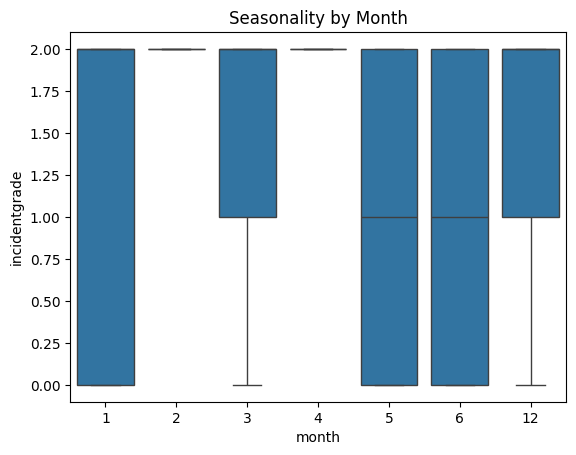

In [134]:
import seaborn as sns

df['month'] = df['timestamp'].dt.month  # Extract month from the timestamp
sns.boxplot(x='month', y='incidentgrade', data=df)  
plt.title('Seasonality by Month')
plt.show()


In [135]:

# df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

# Drop the original timestamp column
df.drop('timestamp', axis=1, inplace=True)

In [136]:
df = df.astype('category')

In [137]:
# 2. Descriptive Statistics
print("\nSummary Statistics:")
df.describe()



Summary Statistics:


,orgid,incidentid,alertid,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,deviceid,sha256,ipaddress,url,accountsid,accountupn,accountobjectid,accountname,devicename,networkmessageid,registrykey,registryvaluename,registryvaluedata,applicationid,applicationname,oauthapplicationid,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,month,year,day,hour,minute
count,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475,99475
unique,2459,49983,81677,2331,11499,18,3,25,2,3032,3948,13446,4349,17975,27899,17797,18816,5087,11297,65,34,46,84,122,18,6007,3408,74,4,14,105,370,849,7,2,31,24,60
top,0,0,0,0,0,InitialAccess,0,Ip,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,6,2024,4,15,27
freq,8887,309,133,14084,14084,45198,43024,22868,54590,95727,91842,76650,92177,76092,63422,76363,74913,92282,87335,99280,99427,99415,97224,97158,99450,88826,90460,99370,97494,97494,91562,92762,92759,90437,99472,9499,5098,1800


In [138]:

value_count = {col: df[col].nunique() for col in df.columns}

value_count_df = pd.DataFrame(list(value_count.items()), columns=['Column', 'Unique Values'])
value_count_df_sorted = value_count_df.sort_values(by='Unique Values',ascending=False)

value_count_df_sorted

,Column,Unique Values
2,alertid,81677
1,incidentid,49983
14,accountupn,27899
16,accountname,18816
13,accountsid,17975
15,accountobjectid,17797
11,ipaddress,13446
4,alerttitle,11499
18,networkmessageid,11297
25,filename,6007


In [139]:
# 3. Target Variable Analysis (`incidentgrade`)
print("\nIncident Grade Distribution:")
df['incidentgrade'].value_counts()


Incident Grade Distribution:


incidentgrade
0    43024
2    34887
1    21564
Name: count, dtype: int64

# Chi-Square Test

In [140]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode categorical features
le = LabelEncoder()
for col in df.select_dtypes(include='category').columns:
    df[col] = le.fit_transform(df[col])
# Define features and target
X = df.drop(columns=['incidentgrade'])  # Replace 'target' with your actual target column
y = df['incidentgrade']


# Apply Chi-Square Test
chi2_values, p_values = chi2(X, y)

# Create DataFrame for better readability
chi2_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': chi2_values
}).sort_values(by='Chi2 Score', ascending=False)

print(chi2_df)


               Feature    Chi2 Score
1           incidentid  1.200595e+08
2              alertid  5.904871e+07
4           alerttitle  2.302879e+07
10           ipaddress  5.339781e+06
14     accountobjectid  4.205763e+06
12          accountsid  4.097439e+06
15         accountname  3.679932e+06
3           detectorid  1.650025e+06
0                orgid  1.469268e+06
13          accountupn  1.255336e+06
17    networkmessageid  1.108658e+06
24            filename  9.212961e+05
25          folderpath  5.341450e+05
16          devicename  3.897893e+05
31                city  3.676481e+05
9               sha256  3.519614e+05
30               state  1.540781e+05
11                 url  1.485808e+05
29         countrycode  5.902805e+04
8             deviceid  2.541720e+04
34                 day  6.612197e+03
5             category  5.763314e+03
6           entitytype  2.698526e+03
35                hour  1.398900e+03
7         evidencerole  1.162155e+03
22     applicationname  2.157759e+02
2

## feature importance

In [141]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Example: Your DataFrame 'df' with features and target column
X = df.drop(columns=['incidentgrade'])  # Replace 'target' with your actual target column
y = df['incidentgrade']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


               Feature  Importance
0                orgid    0.207494
1           incidentid    0.142114
2              alertid    0.102143
3           detectorid    0.099000
4           alerttitle    0.085589
34                 day    0.044952
5             category    0.043311
36              minute    0.035057
35                hour    0.034520
13          accountupn    0.023101
6           entitytype    0.022576
15         accountname    0.016444
10           ipaddress    0.016404
14     accountobjectid    0.016331
12          accountsid    0.016143
17    networkmessageid    0.012452
31                city    0.008896
11                 url    0.008415
29         countrycode    0.008359
16          devicename    0.008285
24            filename    0.007755
25          folderpath    0.007160
9               sha256    0.006844
30               state    0.005912
7         evidencerole    0.005216
32               month    0.004414
8             deviceid    0.004123
22     applicationna

# hist plot

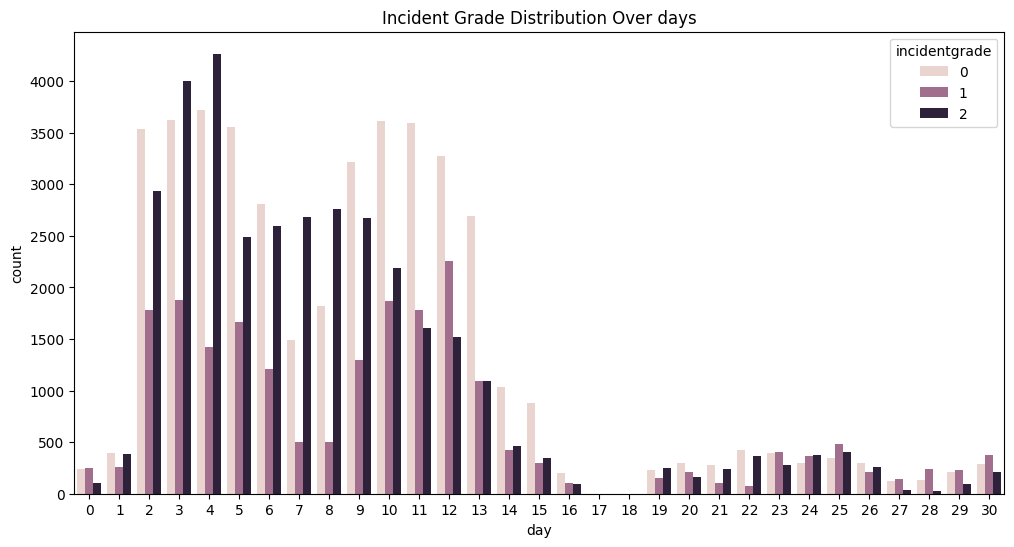

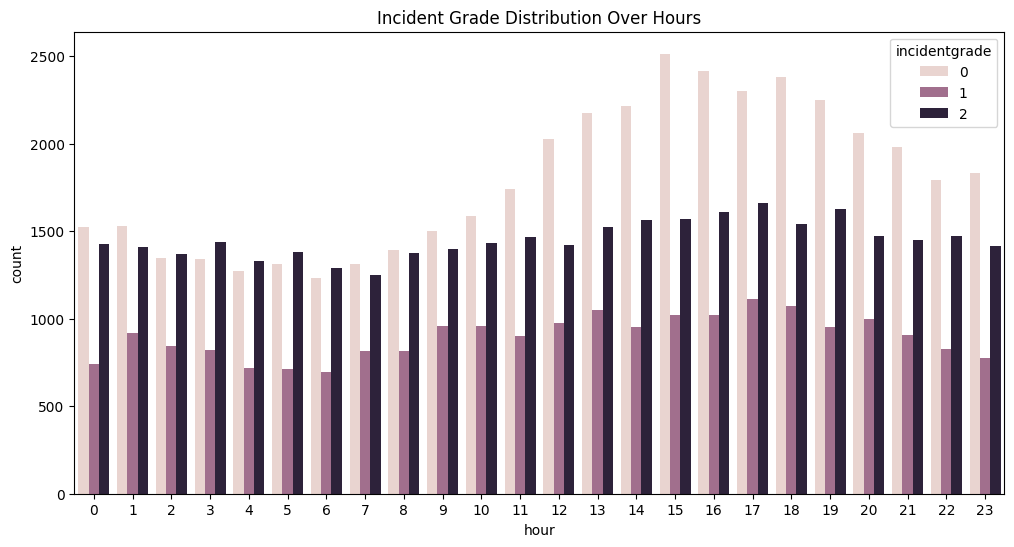

In [142]:
# Analyze the trend of incidentgrade over time
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='day', hue='incidentgrade')
plt.title('Incident Grade Distribution Over days')
plt.show()

# Analyze the trend of incidentgrade over time
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour', hue='incidentgrade')
plt.title('Incident Grade Distribution Over Hours')
plt.show()


# hours
Conclusions:
1 Midday Dominance of Grade 0: The midday hours (12:00 to 15:00) are characterized by a higher prevalence of Grade 0 incidents, suggesting a period of relatively lower severity incidents.
2 Early Morning Spike in Grade 2: There is a clear trend of more severe incidents (Grade 2) occurring during the early morning hours (4:00 to 6:00), which could be crucial for SOCs to focus resources during these times.
3 Stable Presence of Grade 1: Grade 1 incidents are consistently present but do not dominate at any specific hour, making them a steady factor throughout the day.
These trends can help SOCs prioritize their monitoring and response efforts based on the time of day, ensuring that resources are allocated efficiently to handle the most severe incidents during peak hours.


# days:
Conclusions:
The data shows distinct trends in how incident grades are distributed across different days.
There are specific days where one grade dominates completely (like Day 18 and 19), while others see a more even distribution.
Days with sudden spikes or drops in certain grades (e.g., Day 8, 9, 28, 29) might warrant further investigation to understand the underlying causes.

### class Frequency Distribution

Frequency Distribution:
 incidentgrade
0    43024
2    34887
1    21564
Name: count, dtype: int64

Relative Frequency:
 incidentgrade
0    43.251068
2    35.071123
1    21.677808
Name: proportion, dtype: float64

Summary Statistics:
 count    99475.000000
mean         0.918201
std          0.881214
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: incidentgrade, dtype: float64


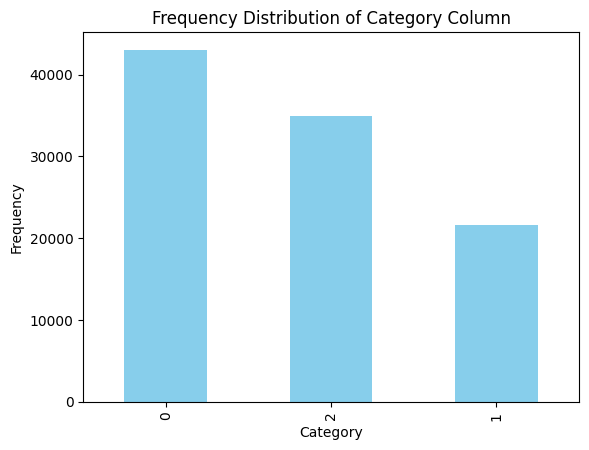

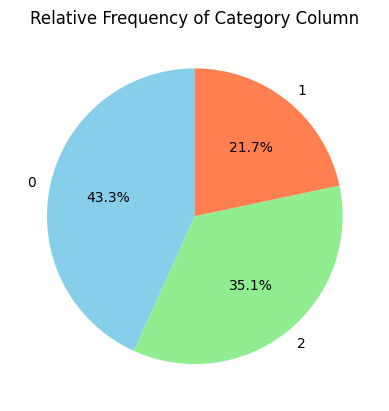

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Frequency Distribution
frequency = df['incidentgrade'].value_counts()
print("Frequency Distribution:\n", frequency)

# Relative Frequency
relative_frequency = df['incidentgrade'].value_counts(normalize=True) * 100
print("\nRelative Frequency:\n", relative_frequency)

# Summary Statistics
summary = df['incidentgrade'].describe()
print("\nSummary Statistics:\n", summary)

# Bar Plot
frequency.plot(kind='bar', color='skyblue')
plt.title('Frequency Distribution of Category Column')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

# Pie Chart
relative_frequency.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'coral'])
plt.title('Relative Frequency of Category Column')
plt.ylabel('')  # Hide y-label
plt.show()

In [144]:
df.columns

Index(['orgid', 'incidentid', 'alertid', 'detectorid', 'alerttitle',
       'category', 'incidentgrade', 'entitytype', 'evidencerole', 'deviceid',
       'sha256', 'ipaddress', 'url', 'accountsid', 'accountupn',
       'accountobjectid', 'accountname', 'devicename', 'networkmessageid',
       'registrykey', 'registryvaluename', 'registryvaluedata',
       'applicationid', 'applicationname', 'oauthapplicationid', 'filename',
       'folderpath', 'resourceidname', 'osfamily', 'osversion', 'countrycode',
       'state', 'city', 'month', 'year', 'day', 'hour', 'minute'],
      dtype='object')

In [145]:
df['incidentgrade'].value_counts()

incidentgrade
0    43024
2    34887
1    21564
Name: count, dtype: int64

In [146]:
df_BenignPositive = df[df['incidentgrade'] == 0]
df_TruePositive = df[df['incidentgrade'] == 1]
df_FalsePositive = df[df['incidentgrade']== 2]

In [147]:
df_BenignPositive.to_csv('BenignPositive.csv')

In [148]:
df['incidentid'].value_counts()

incidentid
0        309
1        190
3        136
27       127
95       126
84       125
6        123
113      122
98       122
115      121
39       121
126      121
108      121
10       121
114      121
18       120
105      120
103      119
22       118
71       118
57       118
37       118
157      117
69       117
46       116
49       116
60       116
2        116
121      115
64       115
65       115
53       114
21       114
88       113
96       113
66       112
102      112
80       112
87       111
76       111
112      111
90       111
133      111
13       110
12       110
136      110
26       110
170      110
36       110
20       110
132      109
74       109
109      109
17       109
89       108
141      108
67       108
122      107
45       107
110      107
28       107
119      107
54       107
70       106
14       106
97       106
52       106
155      106
94       106
79       106
100      106
91       106
40       105
83       105
107      105
34       105
7

In [149]:
# Check cardinality (number of unique values) for each column
cardinality = df.nunique()

# Display the result
print(cardinality)


orgid                  2459
incidentid            49983
alertid               81677
detectorid             2331
alerttitle            11499
category                 18
incidentgrade             3
entitytype               25
evidencerole              2
deviceid               3032
sha256                 3948
ipaddress             13446
url                    4349
accountsid            17975
accountupn            27899
accountobjectid       17797
accountname           18816
devicename             5087
networkmessageid      11297
registrykey              65
registryvaluename        34
registryvaluedata        46
applicationid            84
applicationname         122
oauthapplicationid       18
filename               6007
folderpath             3408
resourceidname           74
osfamily                  4
osversion                14
countrycode             105
state                   370
city                    849
month                     7
year                      2
day                 

## class balance

In [150]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Assuming your dataframe is called 'df' and the column is 'incidentgrade'

# Get the value counts
value_counts = df['incidentgrade'].value_counts()

# Find the minimum count
min_count = value_counts.min()

# Create a list to store the balanced dataframes
balanced_dfs = []

# Undersample each class
for class_value in value_counts.index:
    class_df = df[df['incidentgrade'] == class_value]

    if len(class_df) > min_count:
        # Undersample
        undersampled_df = resample(class_df,
                                   replace=False,    # sample without replacement
                                   n_samples=min_count,
                                   random_state=42)  # reproducible results
        balanced_dfs.append(undersampled_df)
    else:
        # If this class is already at or below the minimum, keep all samples
        balanced_dfs.append(class_df)

# Combine the balanced dataframes
df_balanced = pd.concat(balanced_dfs)

# Verify the new class distribution
print(df_balanced['incidentgrade'].value_counts())

df = df_balanced

incidentgrade
0    21564
2    21564
1    21564
Name: count, dtype: int64


In [151]:
X = df.drop(columns=['incidentgrade']) 
y = df['incidentgrade']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
params = model_rf.get_params()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, confusion_matrix, accuracy_score

# Predict on the test set
y_pred_ = model_rf.predict(X_test)

# Generate the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_)

print("Confusion Matrix:")
print(conf_matrix)

print(classification_report(y_test, y_pred_))
report_dict = classification_report(y_test, y_pred_,output_dict=True)


Confusion Matrix:
[[3859  296  158]
 [ 336 3835  142]
 [ 368  188 3757]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4313
           1       0.89      0.89      0.89      4313
           2       0.93      0.87      0.90      4313

    accuracy                           0.88     12939
   macro avg       0.89      0.88      0.89     12939
weighted avg       0.89      0.88      0.89     12939



# combained csv

In [152]:
import pandas as pd

# Load the CSV files
df1 = pd.read_csv('bp.csv')
df2 = pd.read_csv('fp.csv')
df3 = pd.read_csv('tp.csv')

# Concatenate the DataFrames
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Save the combined DataFrame to a new CSV file (optional)
combined_df.to_csv('combined_file.csv', index=False)
combined_df = combined_df.drop(columns=['Unnamed: 0'])

In [162]:
combined_df.head(5)


,orgid,incidentid,alertid,detectorid,alerttitle,category,incidentgrade,entitytype,evidencerole,deviceid,sha256,ipaddress,url,accountsid,accountupn,accountobjectid,accountname,devicename,networkmessageid,registrykey,registryvaluename,registryvaluedata,applicationid,applicationname,oauthapplicationid,filename,folderpath,resourceidname,osfamily,osversion,countrycode,state,city,month,year,day,hour,minute
36193,100,100,100,100,100,6,0,19,1,3031,3947,13445,4348,17974,27898,17796,18815,5086,11296,64,33,45,83,121,17,6006,3407,73,3,13,104,369,848,5,1,3,22,38
42488,100,100,100,13,11,10,0,24,0,3031,3947,13445,4348,100,100,100,100,5086,11296,64,33,45,83,121,17,6006,3407,73,3,13,104,369,848,5,1,15,1,2
10829,100,100,100,6,5,10,0,14,1,3031,3947,13445,4348,17974,100,17796,18815,5086,3888,64,33,45,83,121,17,6006,3407,73,3,13,104,369,848,5,1,11,0,3
38189,24,67,100,100,100,7,0,14,0,3031,3947,13445,4348,17974,100,17796,18815,5086,3269,64,33,45,83,121,17,6006,3407,73,3,13,104,369,848,5,1,6,21,1
31275,3,100,100,3,100,16,0,24,0,3031,3947,13445,4348,100,100,100,100,5086,11296,64,33,45,83,121,17,6006,3407,73,3,13,104,369,848,5,1,4,17,37


In [154]:
combined_df['incidentgrade'].value_counts()

incidentgrade
0    43024
2    34887
1    21564
Name: count, dtype: int64

In [155]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Assuming your dataframe is called 'df' and the column is 'incidentgrade'

# Get the value counts
value_counts = combined_df['incidentgrade'].value_counts()

# Find the minimum count
min_count = value_counts.min()

# Create a list to store the balanced dataframes
balanced_dfs = []

# Undersample each class
for class_value in value_counts.index:
    class_df = combined_df[combined_df['incidentgrade'] == class_value]

    if len(class_df) > min_count:
        # Undersample
        undersampled_df = resample(class_df,
                                   replace=False,    # sample without replacement
                                   n_samples=min_count,
                                   random_state=42)  # reproducible results
        balanced_dfs.append(undersampled_df)
    else:
        # If this class is already at or below the minimum, keep all samples
        balanced_dfs.append(class_df)

# Combine the balanced dataframes
df_balanced = pd.concat(balanced_dfs)

# Verify the new class distribution
print(df_balanced['incidentgrade'].value_counts())

combined_df = df_balanced

incidentgrade
0    21564
2    21564
1    21564
Name: count, dtype: int64


In [156]:
combined_df.columns

Index(['orgid', 'incidentid', 'alertid', 'detectorid', 'alerttitle',
       'category', 'incidentgrade', 'entitytype', 'evidencerole', 'deviceid',
       'sha256', 'ipaddress', 'url', 'accountsid', 'accountupn',
       'accountobjectid', 'accountname', 'devicename', 'networkmessageid',
       'registrykey', 'registryvaluename', 'registryvaluedata',
       'applicationid', 'applicationname', 'oauthapplicationid', 'filename',
       'folderpath', 'resourceidname', 'osfamily', 'osversion', 'countrycode',
       'state', 'city', 'month', 'year', 'day', 'hour', 'minute'],
      dtype='object')

In [164]:
X = combined_df.drop(columns=['incidentgrade']) 
y = combined_df['incidentgrade']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [157]:


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
params = model.get_params()

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, recall_score, confusion_matrix, accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

# Generate the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

print(classification_report(y_test, y_pred))
report_dict = classification_report(y_test, y_pred,output_dict=True)


Confusion Matrix:
[[4313    0    0]
 [   0 4313    0]
 [   0    0 4313]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4313
           1       1.00      1.00      1.00      4313
           2       1.00      1.00      1.00      4313

    accuracy                           1.00     12939
   macro avg       1.00      1.00      1.00     12939
weighted avg       1.00      1.00      1.00     12939

